In [1]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
import optuna



## Define constans and functions

In [2]:
locations = ["A", "B", "C"]
features_order = []

LAGGED_COLUMNS_TO_KEEP = [
    'direct_rad:W_lag_1h', 
    'direct_rad:W_lag_forward_1h', 
    'clear_sky_rad:W_lag_1h', 
    'clear_sky_rad:W_lag_forward_1h', 
    'diffuse_rad:W_lag_1h', 
    'diffuse_rad:W_lag_forward_1h', 
    'direct_rad_1h:J_lag_1h', 
    'direct_rad_1h:J_lag_forward_1h', 
    'is_in_shadow:idx_lag_1h', 
    'is_in_shadow:idx_lag_forward_1h', 
    'clear_sky_energy_1h:J_lag_1h', 
    'clear_sky_energy_1h:J_lag_forward_1h', 
    'effective_cloud_cover:p_lag_1h', 
    'effective_cloud_cover:p_lag_forward_1h', 
    'visibility:m_lag_1h', 
    'visibility:m_lag_forward_1h', 
    'total_cloud_cover:p_lag_1h', 
    'total_cloud_cover:p_lag_forward_1h', 


    # 'direct_rad:W_lag_2h', 
    # 'direct_rad:W_lag_forward_2h', 
    # 'clear_sky_rad:W_lag_2h', 
    # 'clear_sky_rad:W_lag_forward_2h', 
    # 'diffuse_rad:W_lag_2h', 
    # 'diffuse_rad:W_lag_forward_2h', 
    # 'direct_rad_1h:J_lag_2h', 
    # 'direct_rad_1h:J_lag_forward_2h', 
    # 'is_in_shadow:idx_lag_2h', 
    # 'is_in_shadow:idx_lag_forward_2h', 
    # 'clear_sky_energy_1h:J_lag_2h', 
    # 'clear_sky_energy_1h:J_lag_forward_2h', 
    # 'effective_cloud_cover:p_lag_2h', 
    # 'effective_cloud_cover:p_lag_forward_2h', 
    # 'visibility:m_lag_2h', 
    # 'visibility:m_lag_forward_2h', 
    # 'total_cloud_cover:p_lag_2h', 
    # 'total_cloud_cover:p_lag_forward_2h', 

    # 'direct_rad:W_lag_3h', 
    # 'direct_rad:W_lag_forward_3h', 
    # 'clear_sky_rad:W_lag_3h', 
    # 'clear_sky_rad:W_lag_forward_3h', 
    # 'diffuse_rad:W_lag_3h', 
    # 'diffuse_rad:W_lag_forward_3h', 
    # 'direct_rad_1h:J_lag_3h', 
    # 'direct_rad_1h:J_lag_forward_3h', 
    # 'is_in_shadow:idx_lag_3h', 
    # 'is_in_shadow:idx_lag_forward_3h', 
    # 'clear_sky_energy_1h:J_lag_3h', 
    # 'clear_sky_energy_1h:J_lag_forward_3h', 
    # 'effective_cloud_cover:p_lag_3h', 
    # 'effective_cloud_cover:p_lag_forward_3h', 
    # 'visibility:m_lag_3h', 
    # 'visibility:m_lag_forward_3h', 
    # 'total_cloud_cover:p_lag_3h', 
    # 'total_cloud_cover:p_lag_forward_3h'
]

CUSTOM_COLUMNS_TO_KEEP = [
    "hour_cos",
    "hour_sin",
    "month_sin",
    "month_cos",
    "day-of-year",
]

WEATHER_FEATURES = [
    "direct_rad:W",
    "clear_sky_rad:W",
    "diffuse_rad:W",
    "direct_rad_1h:J",
    "is_in_shadow:idx",
    "clear_sky_energy_1h:J",
    "effective_cloud_cover:p",
    "visibility:m",
    "total_cloud_cover:p",
]


TEST_COLUMNS_TO_KEEP = [
    "direct_rad:W",
    "clear_sky_rad:W",
    "diffuse_rad:W",
    "direct_rad_1h:J",
    "is_in_shadow:idx",
    "clear_sky_energy_1h:J",
    "diffuse_rad_1h:J",
    "is_day:idx",
    "sun_elevation:d",
    "ceiling_height_agl:m",
    "effective_cloud_cover:p",
    "visibility:m",
    "total_cloud_cover:p",
    "air_density_2m:kgm3",
    "wind_speed_v_10m:ms",
    "dew_point_2m:K",
    "wind_speed_u_10m:ms",
    "t_1000hPa:K",
    "absolute_humidity_2m:gm3",
    "snow_water:kgm2",
    "relative_humidity_1000hPa:p",
    "fresh_snow_24h:cm",
    "cloud_base_agl:m",
    "fresh_snow_12h:cm",
    "snow_depth:cm",
    "dew_or_rime:idx",
    "fresh_snow_6h:cm",
    "super_cooled_liquid_water:kgm2",
    "fresh_snow_3h:cm",
    "rain_water:kgm2",
    "precip_type_5min:idx",
    "precip_5min:mm",
    "fresh_snow_1h:cm",
    "sun_azimuth:d",
    "msl_pressure:hPa",
    "pressure_100m:hPa",
    "pressure_50m:hPa",
    "sfc_pressure:hPa",
    "prob_rime:p",
    "wind_speed_10m:ms",
    "elevation:m",
    # "snow_density:kgm3",
    "snow_drift:idx",
    "snow_melt_10min:mm",
    "wind_speed_w_1000hPa:ms",
    "observed_or_estimated"
    # "location_A",
    # "location_B",
    # "location_C",
    # "date_calc",
] + CUSTOM_COLUMNS_TO_KEEP  +   LAGGED_COLUMNS_TO_KEEP

COLUMNS_TO_KEEP = TEST_COLUMNS_TO_KEEP + ["pv_measurement"]



def create_weather_lagged_features(df, weather_features):
    # Choose the weather features for which you want to create lagged versions
    for feature in weather_features:
        # Assuming hourly data, adjust the lags for your specific dataset
        # Creating lagged features for 1 hour, 1 day, and 1 week
        df[f'{feature}_lag_1h'] = df[feature].shift(1)
        # df[f'{feature}_lag_2h'] = df[feature].shift(2)
        # df[f'{feature}_lag_3h'] = df[feature].shift(3)

        df[f'{feature}_lag_forward_1h'] = df[feature].shift(-1)
        # df[f'{feature}_lag_forward_2h'] = df[feature].shift(-2)
        # df[f'{feature}_lag_forward_3h'] = df[feature].shift(-3)
        # df[f'{feature}_lag_24h'] = df[feature].shift(24*4)
        # df[f'{feature}_lag_168h'] = df[feature].shift(24 * 7 * 4 * 365)
        # df[f'{feature}_front_lag_1h'] = df[feature].shift(-4)
        # df[f'{feature}_front_lag_24h'] = df[feature].shift(-24*4)


    # Handling edges by filling NaNs with appropriate values or dropping them
    # You may choose to fill with zeroes or interpolate, based on what makes more sense for your data
    df.fillna(method='ffill', inplace=True)  # Forward fill
    df.fillna(method='bfill', inplace=True)  # Backward fill
    
    return df


def create_lagged_features(df, column_name='pv_measurement'):
    # Assuming 'date_forecast' is the datetime column used for sorting

    df[f'{column_name}_prev_month'] = df[column_name].shift(24*7) # previous week

    # For yearly lag, you would need to calculate the number of observations per year
    # If the data is not consistent (leap years, etc.), you may need a more complex method
    # Here's a simple version assuming 365 days a year:
    df[f'{column_name}_prev_year'] = df[column_name].shift(24*365) # previous year
    df[f'{column_name}_2years_ago'] = df[column_name].shift(24*365*2) # next year

    # Handling edges by filling NaNs with appropriate values or dropping them
    df.fillna(method='ffill', inplace=True)  # Forward fill
    df.fillna(method='bfill', inplace=True)  # Backward fill

    return df


## Prepare data


In [3]:
def add_custom_fields(df):
     df['hour_sin'] = np.sin(2 * np.pi * df['date_forecast'].dt.hour / 24)
     df['hour_cos'] = np.cos(2 * np.pi * df['date_forecast'].dt.hour / 24)

     df['month_sin'] = np.sin(2 * np.pi * df['date_forecast'].dt.month / 12)
     df['month_cos'] = np.cos(2 * np.pi * df['date_forecast'].dt.month / 12)
     df['day-of-year'] = df['date_forecast'].dt.dayofyear
     return df

def remove_outliers(df):
    # Use a mask to filter out the rows where rolling std is zero but keep the rows where the value itself is zero
    mask = (df['pv_measurement'].rolling(5).std() == 0) & (df['pv_measurement'] != 0)
    df = df[~mask]
    return df

def resample_add_data(df, is_test_data):
    df = add_custom_fields(df)
    df.set_index('date_forecast', inplace=True)
    df = df.resample('1H').mean()
    # Remove empty dates if test data
    if is_test_data:
        non_nan_threshold = len(df.columns) // 2  
        df.dropna(thresh=non_nan_threshold, inplace=True)
    df.interpolate(method="linear", inplace=True)
    
    return df

def add_location_feature(X, location):
      # Treat location as a categorical feature by converting it to a category type
    X['location'] = location
    X['location'] = X['location'].astype(str)  # Convert to string if 'location' is not an int
    X['dew_or_rime:idx'] = X['dew_or_rime:idx'].astype(str)
    X['is_day:idx'] = X['is_day:idx'].astype(str)
    X['is_in_shadow:idx'] = X['is_in_shadow:idx'].astype(str)
    categorical_columns = ['location', 'dew_or_rime:idx', 'is_day:idx', 'is_in_shadow:idx']

    # Before filling NaN values, add 'missing' as a category for each categorical column.
    for column in categorical_columns:
        X[column] = X[column].astype('category')  # Ensure the column is of type 'category'.
        if 'missing' not in X[column].cat.categories:
            X[column] = X[column].cat.add_categories(['missing'])  # Add 'missing' as a new category.
        X[column] = X[column].fillna('missing')
    X['location'] = X['location'].astype('category')
    X['dew_or_rime:idx'] = X['dew_or_rime:idx'].astype('category')
    X['is_day:idx'] = X['is_day:idx'].astype('category')
    X['is_in_shadow:idx'] = X['is_in_shadow:idx'].astype('category')
    
    return X

def add_scaling(X_test, X_training, location):
    global scalers
    continuous_columns = X_training.select_dtypes(include=['float32', 'int32']).columns
    if location not in scalers:
        scalers[location] = MinMaxScaler()
    X_training[continuous_columns] = scalers[location].fit_transform(X_training[continuous_columns])
    
    X_test[continuous_columns] = scalers[location].transform(X_test[continuous_columns])

    return X_test, X_training

def make_observed_and_estimated_category(df_observed, df_estimated, df_test):
     # Hot encode in wether observed or estimated
    df_observed['observed_or_estimated'] = 'observed'
    df_estimated['observed_or_estimated'] = 'estimated'
    df_test['observed_or_estimated'] = 'estimated'
    # Concatenate observed and estimated
    df_training = pd.concat([df_observed, df_estimated], axis=0).sort_values(by="date_forecast")
    df_training['observed_or_estimated'] = df_training['observed_or_estimated'].astype('category')
    df_test['observed_or_estimated'] = df_test['observed_or_estimated'].astype('category')

    return df_training, df_test

    
    

In [4]:

# Initialize a dictionary to hold the scalers for each location

scalers = {}


def prepare_data(location):
    # Load data
    scaling = True  # Set scaling to True to enable individual scaling for each location
    global scalers

    # Load training data
    df_observed = pd.read_parquet(f"data/{location}/X_train_observed.parquet")
    df_estimated = pd.read_parquet(f"data/{location}/X_train_estimated.parquet")
    df_target = pd.read_parquet(f"data/{location}/train_targets.parquet")

   
    # Load test data
    df_test = pd.read_parquet(f"data/{location}/X_test_estimated.parquet")

   
    # Hot encode in wether observed or estimated

    # Resample and add custom fields

    df_observed = resample_add_data(df_observed, False)
    df_estimated = resample_add_data(df_estimated, False)
    df_test = resample_add_data(df_test, True)

    df_training, df_test = make_observed_and_estimated_category(df_observed, df_estimated, df_test)

    # Merge training with target data
    df_training = pd.merge(df_training, df_target, left_on="date_forecast", right_on="time", how="inner")
    
    # Create lagged features and remove outliers training
    df_training = create_weather_lagged_features(df_training, WEATHER_FEATURES)
    df_training = df_training[COLUMNS_TO_KEEP]
    df_training = remove_outliers(df_training)

    # Create lagged features test
    df_test = create_weather_lagged_features(df_test, WEATHER_FEATURES)
    df_test = df_test[TEST_COLUMNS_TO_KEEP]

    # Drop nan values for "pv_measurement" in df_training
    # df_training.dropna(subset=["pv_measurement"], inplace=True)

    # Make training x and y
    y_training = df_training["pv_measurement"]
    X_training = df_training.drop("pv_measurement", axis=1)

    # Add categories
    X_training = add_location_feature(X_training, location)
    X_test = add_location_feature(df_test, location)
    
    # Add scaling
    if scaling:
        X_test, X_training = add_scaling(X_test, X_training, location)
    X_test.reset_index(inplace=True)
    X_test.drop("date_forecast", axis=1, inplace=True)
    # y_training = np.log1p(y_training)
    if location == "B" or location == "C":
        y_training = (y_training)
    return X_training, X_test, y_training



# Use prepare_data function

combined_X_train = pd.DataFrame()
combined_X_val = pd.DataFrame()
combined_Y_train = pd.DataFrame()
combined_Y_val = pd.DataFrame()
combined_X_test = pd.DataFrame()

# For validation locally 
locations_training = {}
for location in locations:
    # Prepare the training data
    X_training, X_test, y_training = prepare_data(location)
    
    # Split and concatenate the training data
    X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size=0.2, random_state=42)
    combined_X_train = pd.concat([combined_X_train, X_train])
    combined_X_val = pd.concat([combined_X_val, X_val])
    combined_Y_train = pd.concat([combined_Y_train, y_train])
    combined_Y_val = pd.concat([combined_Y_val, y_val])
    locations_training[location] = X_train
    combined_X_test = pd.concat([combined_X_test, X_test])

    # Spl


combined_X_train, combined_Y_train = shuffle(combined_X_train, combined_Y_train, random_state=42)
combined_X_val, combined_Y_val = shuffle(combined_X_val, combined_Y_val, random_state=42)

## Train

In [43]:
def train_model(X_train, y_train, X_val, y_val, location):
    cat_features = [index for index, col in enumerate(X_train.columns) if col in ['location', 'dew_or_rime:idx', 'is_day:idx', 'is_in_shadow:idx', 'observed_or_estimated']]
    
    model = CatBoostRegressor(
        iterations=6000,
        learning_rate=0.007,
        depth=12,  # assuming you decided to keep the depth reduced
        loss_function='MAE',
        verbose=200,
        cat_features=cat_features,
    )

    # Use the provided validation set for early stopping
    
    model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)
    model.save_model(f"catboost_model_merged.cbm")

def evaluate_model(X_val, y_val, location):
    model = CatBoostRegressor()
    model.load_model(f"catboost_model_merged.cbm")
    
    # Unique locations in the X_val dataframe
    locations = X_val['location'].unique()
    
    for location in locations:
        # Filter X_val and y_val for the current location
        X_val_loc = X_val[X_val['location'] == location]
        y_val_loc = y_val[X_val['location'] == location]
        
        # Make predictions
        y_pred_loc = model.predict(X_val_loc)
        
        # Apply the transformation if needed (assuming y_val_loc and y_pred_loc are log1p transformed)
        # y_val_loc = np.expm1(y_val_loc)
        # y_pred_loc = np.expm1(y_pred_loc)
        
        # Calculate MAE for the current location
        mae = mean_absolute_error(y_val_loc, y_pred_loc)
        print(f'Location {location}, Mean Absolute Error: {mae}')


# Train the model using all available training data and the initial validation set for early stopping
train_model(combined_X_train, combined_Y_train, combined_X_val, combined_Y_val, location)
# Evaluate the model using the same validation set
evaluate_model(combined_X_val, combined_Y_val, location)


0:	learn: 557.4758756	test: 550.2353404	best: 550.2353404 (0)	total: 159ms	remaining: 15m 53s
200:	learn: 228.0696761	test: 226.7264875	best: 226.7264875 (200)	total: 18.9s	remaining: 9m 4s
400:	learn: 163.1040274	test: 167.0994280	best: 167.0994280 (400)	total: 37.2s	remaining: 8m 38s
600:	learn: 144.7086134	test: 153.6758019	best: 153.6758019 (600)	total: 55.5s	remaining: 8m 18s
800:	learn: 135.6079455	test: 148.1745227	best: 148.1745227 (800)	total: 1m 13s	remaining: 7m 59s
1000:	learn: 132.5707420	test: 146.2401252	best: 146.2401252 (1000)	total: 1m 31s	remaining: 7m 37s
1200:	learn: 129.8245170	test: 144.6840764	best: 144.6840764 (1200)	total: 1m 49s	remaining: 7m 16s
1400:	learn: 126.6441321	test: 142.9687763	best: 142.9687763 (1400)	total: 2m 7s	remaining: 6m 57s
1600:	learn: 122.0626587	test: 140.5982789	best: 140.5982789 (1600)	total: 2m 25s	remaining: 6m 39s
1800:	learn: 117.2894847	test: 138.2114323	best: 138.2114323 (1800)	total: 2m 43s	remaining: 6m 22s
2000:	learn: 114.88

## Optimalize hyperparameters

In [5]:

CATEGORICAL_COLUMNS = [
    "location",
    "dew_or_rime:idx",
    "is_day:idx",
    "is_in_shadow:idx",
    "observed_or_estimated",
]

def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 4000, 14000),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
        "depth": trial.suggest_int("depth", 8, 13),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 200),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 30),
    }

    cat_features = [index for index, col in enumerate(X_train.columns) if col in CATEGORICAL_COLUMNS]

    model = CatBoostRegressor(**params, silent=True, cat_features=cat_features)
    model.fit(combined_X_train, combined_Y_train, eval_set=(combined_X_val, combined_Y_val), use_best_model=True)
    predictions = model.predict(combined_X_val)
    mae = mean_absolute_error(combined_Y_val, predictions)
    return mae

def find_optimal_hyperparameters_using_optuna():
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=80)
    print('Best hyperparameters:', study.best_params)
    print('Best RMSE:', study.best_value)

find_optimal_hyperparameters_using_optuna()

[I 2023-11-09 01:40:14,782] A new study created in memory with name: no-name-a2a3dcbd-81b9-4948-90c8-653faae17f18


[I 2023-11-09 01:42:44,715] Trial 0 finished with value: 76.72253911925925 and parameters: {'iterations': 9598, 'learning_rate': 0.006889449078007475, 'depth': 10, 'subsample': 0.23515353473190642, 'colsample_bylevel': 0.3702330673107029, 'min_data_in_leaf': 104, 'l2_leaf_reg': 30}. Best is trial 0 with value: 76.72253911925925.
[I 2023-11-09 01:44:39,923] Trial 1 finished with value: 74.84268196041612 and parameters: {'iterations': 12793, 'learning_rate': 0.009042306784419477, 'depth': 10, 'subsample': 0.1482587901754649, 'colsample_bylevel': 0.14563298169683636, 'min_data_in_leaf': 15, 'l2_leaf_reg': 26}. Best is trial 1 with value: 74.84268196041612.
[I 2023-11-09 01:53:13,061] Trial 2 finished with value: 71.47392263949067 and parameters: {'iterations': 8255, 'learning_rate': 0.01529565581647042, 'depth': 12, 'subsample': 0.21987550443474363, 'colsample_bylevel': 0.9028925412798778, 'min_data_in_leaf': 1, 'l2_leaf_reg': 28}. Best is trial 2 with value: 71.47392263949067.
[I 2023-11

KeyboardInterrupt: 

## Make predictions

In [44]:

# Assuming you have defined WEATHER_FEATURES, TEST_COLUMNS_TO_KEEP, and other functions previously

def make_predictions(df_test_pred):
    
    # Load model 
    model = CatBoostRegressor()
    model.load_model(f"catboost_model_merged.cbm")

    preds = model.predict(df_test_pred)
    
    # Inverse transform the predictions
    # preds = np.expm1(preds)
    return preds





## Evaluate locally


Number of predictions that are a lower value than the actual, given that the actual is not 0: 315
Number of predictions that are larger than the target, given that the target is not 0: 156
The biggest misread is at index 490 with a difference of 5002.449709160428


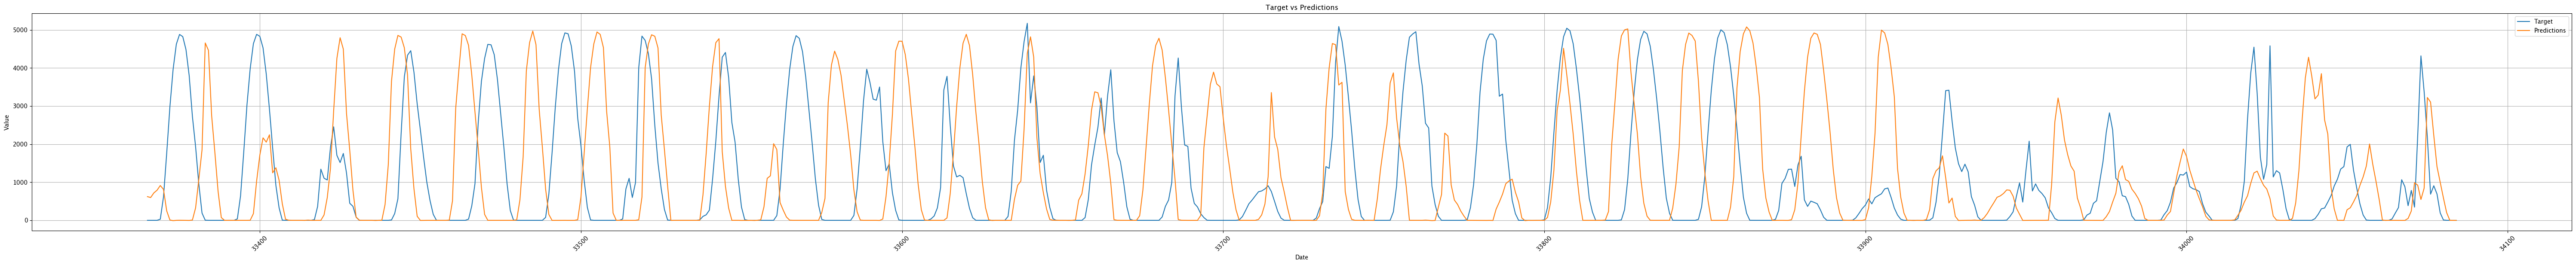

Number of predictions that are a lower value than the actual, given that the actual is not 0: 246
Number of predictions that are larger than the target, given that the target is not 0: 215
The biggest misread is at index 533 with a difference of 5055.841951523498


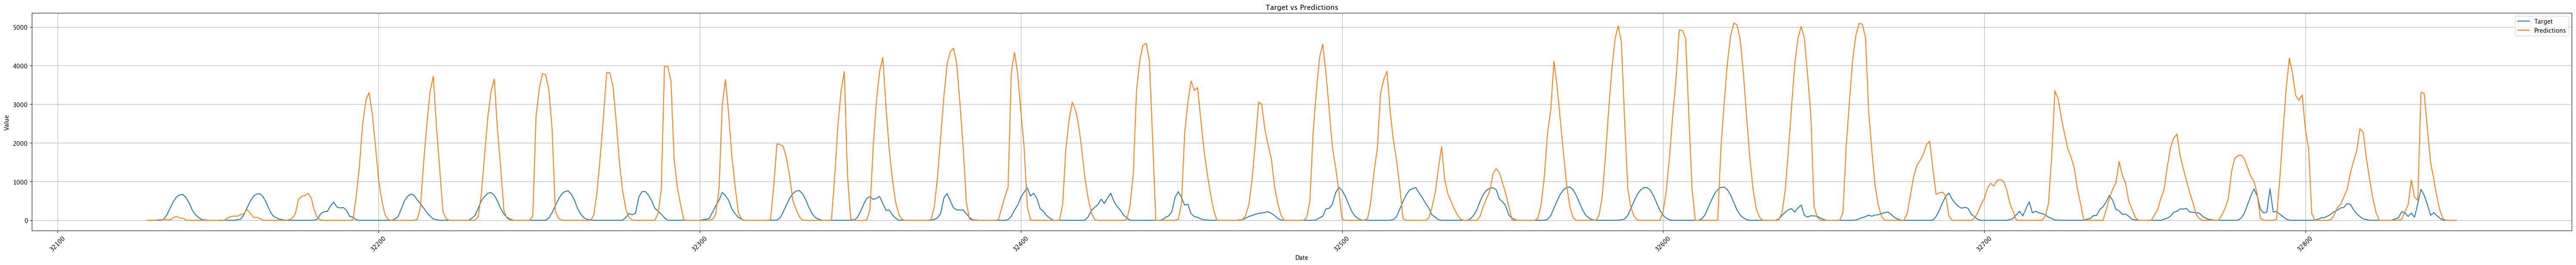

Number of predictions that are a lower value than the actual, given that the actual is not 0: 208
Number of predictions that are larger than the target, given that the target is not 0: 247
The biggest misread is at index 672 with a difference of 4936.304973759295


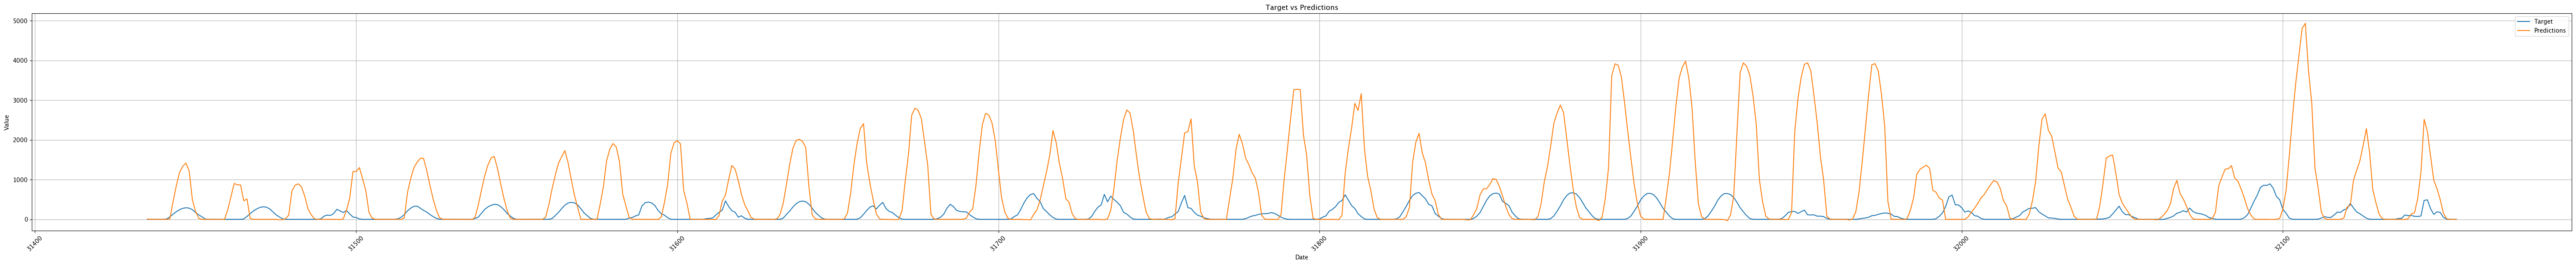

In [45]:
import matplotlib.pyplot as plt


def evaluate_model_locally(location, data):
    # Load the test data
    target_df = pd.read_parquet(f"data/{location}/train_targets.parquet")
    
    # Make predictions
    preds = make_predictions(data)[-720:]
    target = target_df.tail(720)["pv_measurement"].to_numpy()
    
    differences = preds - target
    # Count predictions lower than the actual
    lower_predictions = (differences < 0) & (target != 0)
    # Count predictions higher than the actual
    higher_predictions = (differences > 0) & (target != 0)

    # Biggest misreads
    absolute_differences = abs(differences)
    max_diff_index = absolute_differences.argmax()  # Index of the biggest difference
    max_diff_value = absolute_differences[max_diff_index]  # Value of the biggest difference
    print(f"Number of predictions that are a lower value than the actual, given that the actual is not 0: {lower_predictions.sum()}")
    print(f"Number of predictions that are larger than the target, given that the target is not 0: {higher_predictions.sum()}")
    print(f"The biggest misread is at index {max_diff_index} with a difference of {max_diff_value}")
    
    index = target_df.index[-720:]
    # Plotting
    plt.figure(figsize=(60,6))
    plt.plot(index, target, label="Target")
    plt.plot(index, preds, label="Predictions")
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Target vs Predictions')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()

for loc in locations:

    training_data = locations_training[loc].sort_index()
    evaluate_model_locally(loc, training_data)


## Submit to csv 1

In [38]:
df_submission = pd.read_csv("data/test.csv")

preds = make_predictions(combined_X_test)
print(len(preds))
print(len(df_submission))
df_submission["prediction"] = preds

# Save the results to a new submission file
df_submission[["id", "prediction"]].to_csv("kaggle_submission_catboost_11.csv", index=False)

2160
2160
